In [34]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

import pickle

from xmljson import badgerfish as bf
from xml.etree.ElementTree import fromstring

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = '/Users/haohe/Documents/HKUST/competition/data/VisDrone2021-COUNTING/DroneRGBT'
train_images = path + '/Train/RGB'
train_images_TIR = path + '/Train/TIR'
anno = path + '/Train/GT_'
dmap_folder = path + '/Train/DMAP'

# Some Help function, move to uti later

In [117]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(12, 12))

        ax[0].imshow(image)
        ax[1].imshow(mask)
        print(mask.sum())
    else:
        f, ax = plt.subplots(2, 2, figsize=(12, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)

        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)

        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)

        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
        #print(mask.sum())
        
        
def plot_data(img,points,fig_size=(18,12)):
    p_img = img.copy()
    fig, ax = plt.subplots(1, 1, figsize=fig_size)
    for point in points:
        cv2.circle(p_img, tuple(point), radius=0,color=(0, 1, 0), thickness=5)
    ax.imshow(p_img)

# Dataset 

In [132]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            #A.RandomSizedCrop(min_max_height=(409, 512), height=409, width=512, p=1.0),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=1.0),
        ],
        #additional_targets={'image': 'image','image1': 'image'}
        keypoint_params = A.KeypointParams(format='xy')
)

def get_train_image_only_transforms():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.Blur(blur_limit=3,p=0.2),
            A.Normalize(p=1.0,max_pixel_value=1.0),
            ToTensorV2(p=1.0),
        ],
        additional_targets={'image': 'image'}
    )

In [137]:
class Counting_Dataset(Dataset):
    def __init__(self,path,images_folder,dmap_folder,gt_folder=None,suffix='jpg',transforms=None,mosaic=False):
        super().__init__()
        self.path = path
        self.images_path = path + images_folder
        self.image_fnames = glob(self.images_path+f'/*.{suffix}')
        self.dmap_folder = path + dmap_folder
        self.transforms = transforms
        self.mosaic = mosaic
        self.gt_folder = gt_folder # test purpose
        
    def __len__(self):
        return len(self.image_fnames)
    
    def __getitem__(self,idx):
        image_id = self.image_fnames[idx]
        
        if self.mosaic and random.randint(0,1) < 0.5:
            image, density_map, gt_points = self._load_mosaic_image_and_density_map(idx)
        else:
            image, density_map, gt_points = self._load_image_and_density_map(idx)
        
        # Warning: doesn't work for cutout, uncommet transform and make fix code to enable cutout
        # Reason: cutout doesn't apply to mask, so mask must be image. check 01a bottom for code
        for tfms in self.transforms:
            aug = tfms(**{
                'image': image,
                'mask': density_map,
                'keypoints': gt_points
            })
            image, density_map, gt_points = aug['image'], aug['mask'], aug['keypoints']
        
        return image, density_map, image_id, gt_points
        
    
    def _get_dmap_name(self,fn):
        mask_name = fn.split('/')[-1].split('.')[0]
        mask_path = self.dmap_folder + '/' + mask_name + 'Dmap.pkl'
        return mask_path
    
    def _load_image_and_density_map(self,idx):
        image_fname = self.image_fnames[idx]
        dmap_fname = self._get_dmap_name(image_fname)
        image = cv2.imread(image_fname)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.
        d_map = np.load(dmap_fname,allow_pickle=True)
        
        #sanity check gt
        _, points = self._get_gt_data(idx)
        # end sanity check
        
        return image, d_map, points
    
    def _load_mosaic_image_and_density_map(self,idx):
        image_1, dmap_1, points_1 = self._load_image_and_density_map(idx)
        while True:
            idx_2 = random.randint(0,len(self.image_fnames)-1)
            if idx != idx_2:
                break
        image_2, dmap_2, points_2 = self._load_image_and_density_map(idx_2)
        
        imsize = min(*image_1.shape[:2])
        xc,yc = [int(random.uniform(imsize*0.4,imsize*0.6)) for _ in range(2)]
        h,w = image_1.shape[0], image_1.shape[1]

        pos = random.randint(0,1)
        if pos == 0: #top left
            x1a,y1a,x2a,y2a = 0,0,xc,yc # img_1
            x1b,y1b,x2b,y2b = w-xc,h-yc,w,h # img_2
        elif pos == 1: # top right
            x1a,y1a,x2a,y2a = w-xc,0,w,yc
            x1b,y1b,x2b,y2b = 0,h-yc,xc,h
        elif pos == 2: # bottom left
            x1a,y1a,x2a,y2a = 0,h-yc,xc,h
            x1b,y1b,x2b,y2b = w-xc,0,w,yc
        elif pos == 3: # bottom right
            x1a,y1a,x2a,y2a = w-xc,h-yc,w,h
            x1b,y1b,x2b,y2b = 0,0,xc,yc
        
        new_image = image_1.copy()
        new_dmap = dmap_1.copy()
        new_image[y1a:y2a,x1a:x2a] = image_2[y1b:y2b,x1b:x2b]
        new_dmap[y1a:y2a,x1a:x2a] = dmap_2[y1b:y2b,x1b:x2b]
        
        #TODO: sanity check to see generate gt
        
        new_gt_points = self._get_mixed_gt_points(points_1,points_2,(x1a,y1a,x2a,y2a),(x1b,y1b,x2b,y2b),(h,w))
        
        return new_image, new_dmap, new_gt_points
    
    '''
    The follow section blocks are for sanity check 
    to compare dmap.sum() with gt points
    remove if needed
    '''
    def _get_mixed_gt_points(self,points_1,points_2,img_1_loc, img_2_loc,img_shape):
#         fn_1, points_1 = self._get_gt_data(idx_1)
#         fn_2, points_2 = self._get_gt_data(idx_2)
        x1a,y1a,x2a,y2a = img_1_loc
        x1b,y1b,x2b,y2b = img_2_loc
        h,w = img_shape
        
        result_boxes = []
        result_boxes.append(points_2)
        result_boxes = np.concatenate(result_boxes,0)
        padw = x1a-x1b
        pady = y1a-y1b

        result_boxes[:,0] += padw
        result_boxes[:,1] += pady

        np.clip(result_boxes[:,0],0,w+1,out=result_boxes[:,0])
        np.clip(result_boxes[:,1],0,h+1,out=result_boxes[:,1])
        result_boxes = result_boxes.astype(np.int32)

        result_boxes = result_boxes[np.where(result_boxes[:,0] * result_boxes[:,1] > 0)]
        result_boxes = result_boxes[np.where(result_boxes[:,0] < w+1)]
        result_boxes = result_boxes[np.where(result_boxes[:,1] < h+1)]
        
        boxes = []
        for (x,y) in points_1:
            if x >= x1a and x <= x2a and y >= y1a and y <= y2a:
                continue
            else:
                boxes.append((x,y))
        return np.concatenate((boxes, result_boxes),axis=0)
    
    def _get_gt_data(self,idx):
        if not self.gt_folder:
            return (None,0)
        fn = self.image_fnames[idx]
        anno_path = self.path + self.gt_folder + '/' + fn.split('/')[-1].split('.')[0] + 'R.xml'
        with open(anno_path,'r') as f:
                data = f.read()
        test_data = bf.data(fromstring(data))
        points = self._get_annotation(test_data)
        return fn, points
        
    
    def _get_annotation(self,xml_datas):
        points = []
        for data in xml_datas['annotation']['object']:
            if data['name']['$'] == 'person':
                if 'point' in data:
                    x = data['point']['x']['$']
                    y = data['point']['y']['$']
                else:
                    x = data['bndbox']['xmin']['$']
                    y = data['bndbox']['ymin']['$']
                points.append((x,y))
            else: print(data['name']['$'] +' not a person...')
        return points
        

In [134]:
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [138]:
train_dataset = Counting_Dataset(path=path,
                                 images_folder='/Train/RGB',dmap_folder='/Train/DMAP',
                                 gt_folder='/Train/GT_',
                                 transforms=[get_train_transforms(),get_train_image_only_transforms()],
                                 mosaic=True
                                )

In [151]:
img,dmap,fn,points = train_dataset[10]

In [152]:
img = img * std[...,None,None] + mean[...,None,None]
img = img.permute(1,2,0).cpu().numpy()

tensor(12.7057)


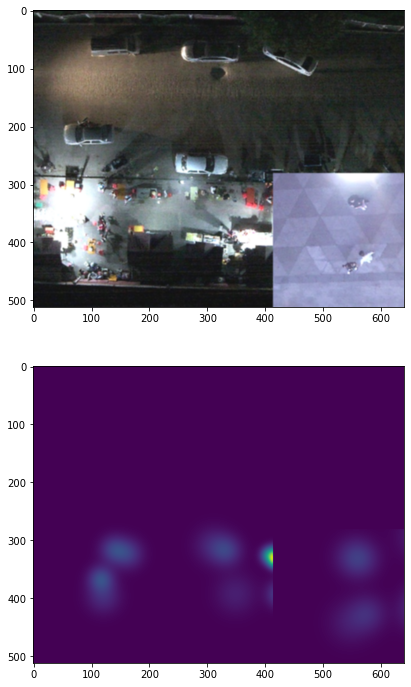

In [153]:
visualize(img,dmap)

In [154]:
len(points), dmap.sum()

(12, tensor(12.7057))

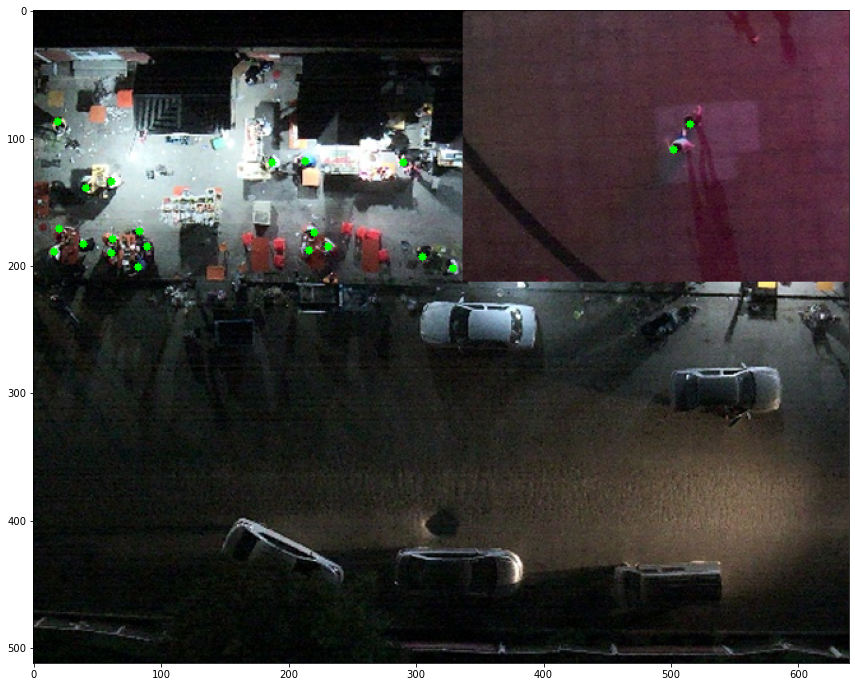

In [143]:
plot_data(img,points)

In [144]:
img,dmap,fn,points = train_dataset[100]

tensor(259.0906)


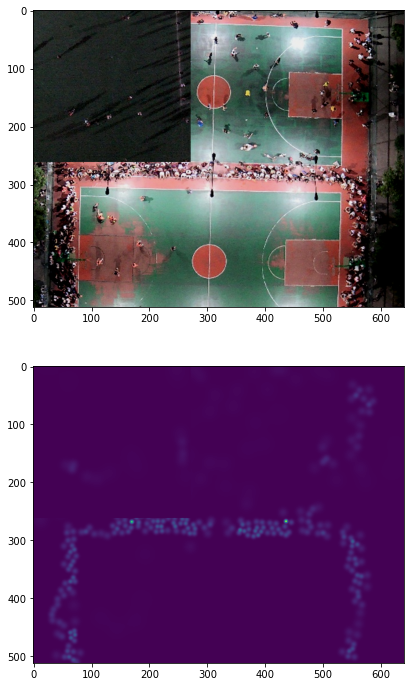

In [147]:
img = img * std[...,None,None] + mean[...,None,None]
img = img.permute(1,2,0).cpu().numpy()
visualize(img,dmap)

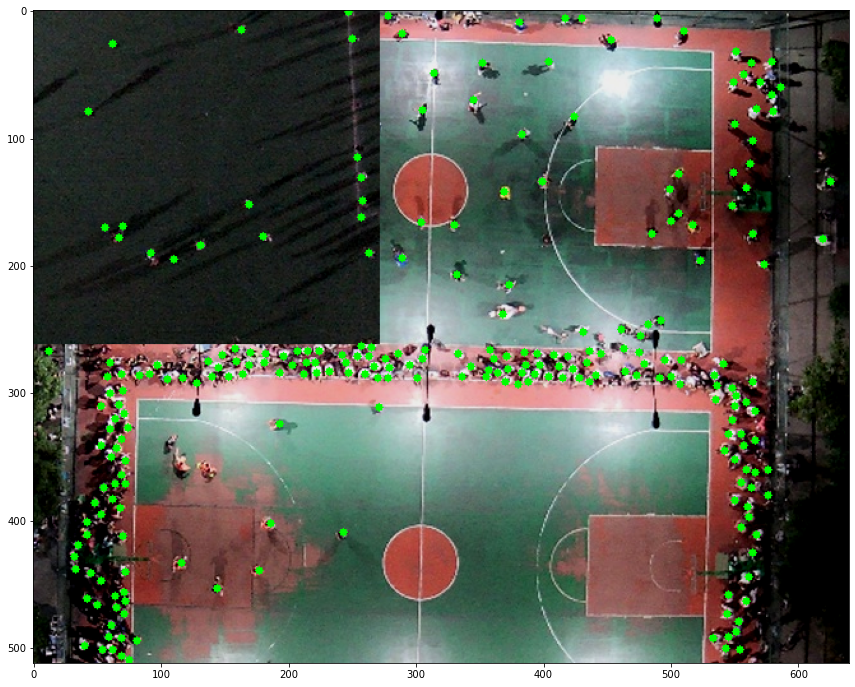

In [148]:
plot_data(img,points)

In [150]:
len(points),dmap.sum()

(259, tensor(259.0906))

tensor(59.6168)


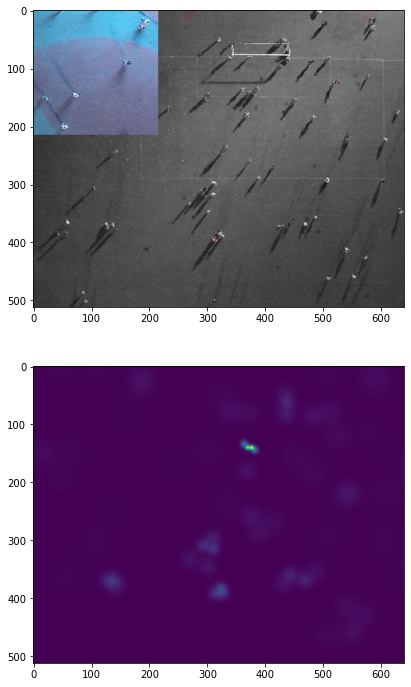

In [155]:
img,dmap,fn,points = train_dataset[300]
img = img * std[...,None,None] + mean[...,None,None]
img = img.permute(1,2,0).cpu().numpy()
visualize(img,dmap)

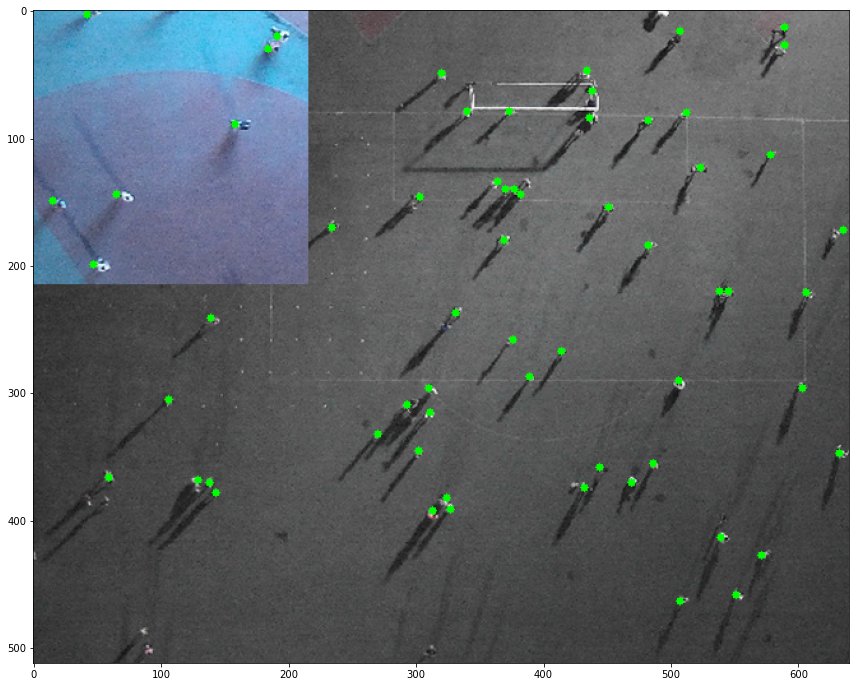

In [156]:
plot_data(img,points)

In [157]:
len(points),dmap.sum()

(62, tensor(59.6168))

tensor(18.7057)


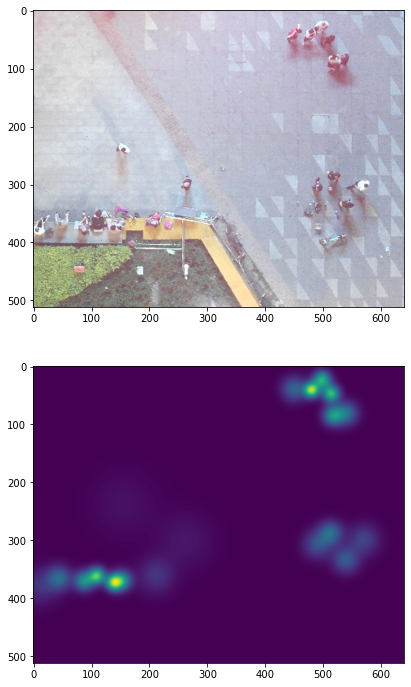

In [158]:
img,dmap,fn,points = train_dataset[1200]
img = img * std[...,None,None] + mean[...,None,None]
img = img.permute(1,2,0).cpu().numpy()
visualize(img,dmap)

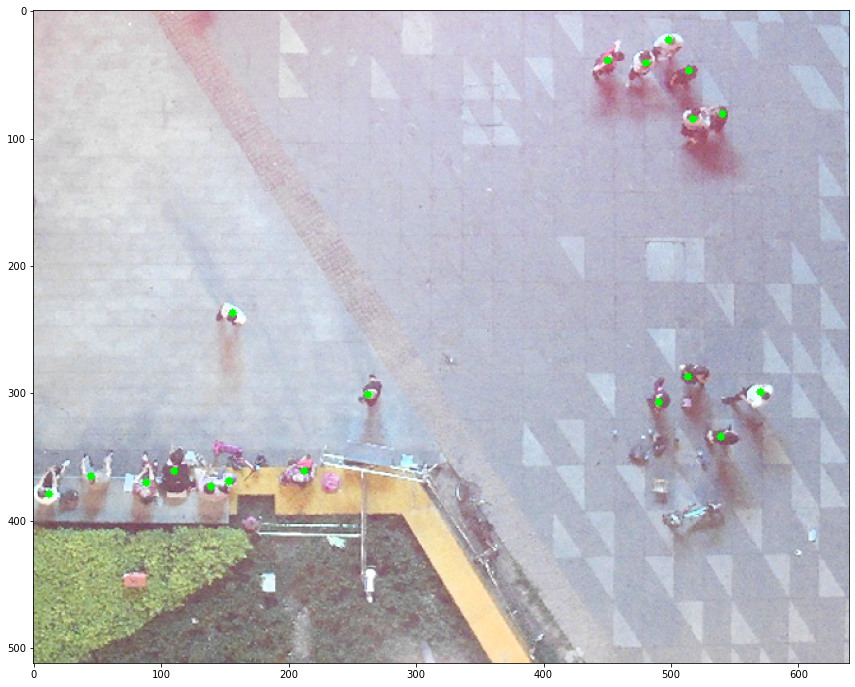

In [159]:
plot_data(img,points)

In [160]:
len(points),dmap.sum()

(19, tensor(18.7057))